In [1]:
from core.data.data import Dataset
from core.data.makeedge import make_edge_files
from core.data.utils import image_transform, edge_transform
from PIL import Image
import os
from torch.utils.data import DataLoader


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

from core.network.smoothingnetwork import  SmoothingNet
from core.loss.dataloss import DataLoss
from core.loss.smoothnessloss import SmoothnessLoss
from core.loss.edgepreservingloss import EdgePreservingLoss

In [2]:
root = 'data'
ds = Dataset(os.path.join(root, "eval"), os.path.join(root, "eval_edges"))
dl = DataLoader(ds)


#%%
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.Adam([input_img.requires_grad_()])
    return optimizer

#%%
def run(input_img, original_img, mask, num_steps=200, image_size=224, device='cpu'):
    """Run the image smoothing."""
    print('Building the Smoothing model..')
    dataloss = DataLoss().to(device)
    smoothloss = SmoothnessLoss(image_size=image_size, window_size=10).to(device)
    edgeloss = EdgePreservingLoss(image_size=image_size).to(device)
    
    w_d = 1.0
    w_s = 1.0
    w_e = 0.1
    
    original_img = original_img.detach().to(device)
    input_img = input_img.to(device)
    residual = torch.zeros_like(input_img.detach())
    mask = mask.to(device)
    
    optimizer = get_input_optimizer(residual)
    

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:
        
        def closure():
        
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            D = w_d * dataloss(original_img, input_img+residual)
            S = w_s * smoothloss(original_img, input_img+residual)
            E = w_e * edgeloss(mask, original_img, input_img+residual)
            loss = D + S + E
            loss.backward()

            
            if run[0] % 10 == 0:
                print("run {}:".format(run))
                print('D : {:4f} S: {:4f} E: {:4f}'.format(
                    D.item(), S.item(), E.item()))
                print()
            run[0] += 1
            return loss
        
        optimizer.step(closure)
            
            

    # a last correction...
    input_img.data.clamp_(0, 1)
    
    return input_img+residual

In [3]:
def imshow(tensor, title=None):
    unloader = transforms.ToPILImage()
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

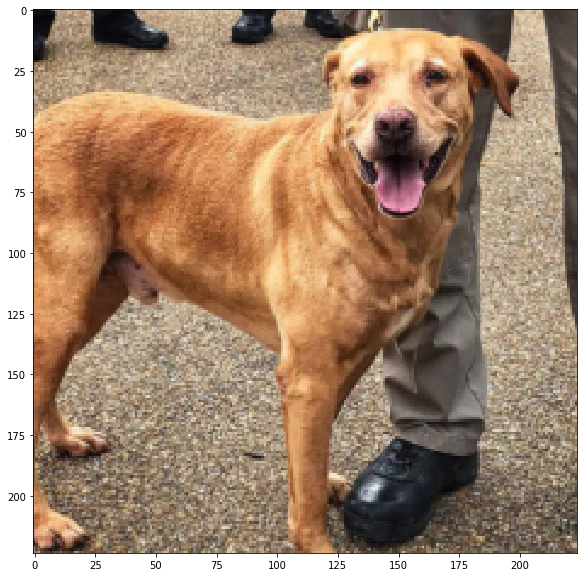

In [4]:
img, mask = ds[0]
img, mask = img.unsqueeze(0), mask.unsqueeze(0)

# img = torch.tensor([
#     [0.1,0.1,1.0,0.1,0.1],
#     [0.1,0.8,1.0,1.0,0.1],
#     [1,1,0.9,1,1],
#     [0.1,1,0.8,1,0.1],
#     [0.1,0.1,1,0.1,0.1]
# ]).view(1,1,5,5).repeat(1,3,1,1)

# mask = torch.tensor([
#     [0.,0.,1.,0.,0.],
#     [0.,1.,0.,1.,0.],
#     [1.,0.,0.,0.,1.],
#     [0.,0.,1.,0.,0.],
#     [0.,1.,0.,1.,0.]
# ]).view(1,1,5,5).repeat(1,3,1,1)
original_img = img.clone().detach()
imshow(img)

In [5]:
out = run(img, original_img, mask, num_steps=100,image_size=224, device='cuda')

Building the Smoothing model..
Optimizing..
run [0]:
D : 0.000000 S: 0.338029 E: 0.000000

run [10]:
D : 0.000076 S: 0.305547 E: 0.002400

run [20]:
D : 0.000249 S: 0.278095 E: 0.007280

run [30]:
D : 0.000465 S: 0.255765 E: 0.012357

run [40]:
D : 0.000695 S: 0.237651 E: 0.017011

run [50]:
D : 0.000922 S: 0.222862 E: 0.021150

run [60]:
D : 0.001135 S: 0.210946 E: 0.024678

run [70]:
D : 0.001327 S: 0.201642 E: 0.027499

run [80]:
D : 0.001500 S: 0.194310 E: 0.029745

run [90]:
D : 0.001652 S: 0.188557 E: 0.031550

run [100]:
D : 0.001788 S: 0.183906 E: 0.033005



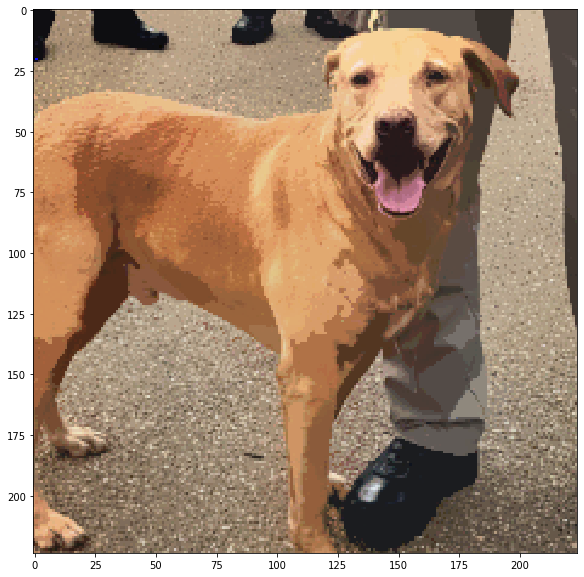

In [6]:
imshow(out)